In [ ]:
import urllib, json
def generate_toc(notebook_path, indent_char="&emsp;"):
    is_markdown = lambda it: "markdown" == it["cell_type"]
    is_title = lambda it: it.strip().startswith("#") and it.strip().lstrip("#").lstrip()
    with open(notebook_path, 'r') as in_f:
        nb_json = json.load(in_f)
    for cell in filter(is_markdown, nb_json["cells"]):
        for line in filter(is_title, cell["source"]):
            line = line.strip()
            indent = indent_char * (line.index(" ") - 1)
            title = line.lstrip("#").lstrip()
            url = urllib.parse.quote(title.replace(" ", "-"))
            out_line = f"{indent}[{title}](#{url})<br>\n"
            print(out_line, end="")
generate_toc('Martinez_Eva_2_notebook_prediction_SiteEnergyUse_102022.ipynb')

[Import lib](#Import-lib)<br>
[Import data csv](#Import-data-csv)<br>
&emsp;[Energy consumption on a map](#Energy-consumption-on-a-map)<br>
[Prediction](#Prediction)<br>
&emsp;[Step 1 :Build pre-processing pipeline](#Step-1-%3ABuild-pre-processing-pipeline)<br>
&emsp;&emsp;[Split train/test](#Split-train/test)<br>
&emsp;[Step 2 : Evaluate some models](#Step-2-%3A-Evaluate-some-models)<br>
&emsp;&emsp;[SVR](#SVR)<br>
&emsp;&emsp;[Ridge](#Ridge)<br>
&emsp;&emsp;[Knn](#Knn)<br>
&emsp;&emsp;[Decision Tree](#Decision-Tree)<br>
&emsp;&emsp;[Gradient Boosting](#Gradient-Boosting)<br>
&emsp;&emsp;[Random Forest](#Random-Forest)<br>
&emsp;&emsp;[Summary Score](#Summary-Score)<br>
&emsp;&emsp;[Try log of target for best model : Gradient Boosting](#Try-log-of-target-for-best-model-%3A-Gradient-Boosting)<br>
&emsp;[Step 3 : Model Optimization of hyperparameters with Gridsearch (with log(target))](#Step-3-%3A-Model-Optimization-of-hyperparameters-with-Gridsearch-%28with-log%28target%29%29)<br>
&ems

# Import lib

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.__config__ import show
import scipy.stats as stats
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler

from sklearn import svm
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import KFold
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report, f1_score, average_precision_score, precision_recall_fscore_support)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor






# Import data csv

In [3]:
df_cleaned = pd.read_csv('/content/df_cleaned.csv')
print(df_cleaned.head(3))

   Unnamed: 0  SiteEnergyUse(kBtu)  TotalGHGEmissions PrimaryPropertyType  \
0           0            7226362.5             249.98               Hotel   
1           1            8387933.0             295.86               Hotel   
2           2           72587024.0            2089.28               Hotel   

   Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
0  47.61220 -122.33799       1927                1.0              12   
1  47.61317 -122.33393       1996                1.0              11   
2  47.61393 -122.33810       1969                1.0              41   

   PropertyGFABuilding(s)  PropertyGFAParking  ENERGYSTARScore  \
0                   88434                   0             60.0   
1                   88502               15064             61.0   
2                  759392              196718             43.0   

   proportion_SteamUse(kBtu)  proportion_Electricity(kBtu)  \
0                   0.277302                      0.546060   
1            

## Energy consumption on a map

In [4]:
df_cleaned = pd.read_csv('/content/df_cleaned.csv')

import folium

latmean = df_cleaned['Latitude'].mean()
lonmean = df_cleaned['Longitude'].mean()
map = folium.Map(location=[latmean,lonmean], 
        zoom_start=6) 

def color(value): 
    if value in range(0,1216332): 
        col = 'green'
    elif value in range(1216333,2729167): 
        col = 'orange'
    else: 
        col='red'
    return col 
      
map = folium.Map(location=[latmean,lonmean], 
        zoom_start=6) 

df_cleaned['SiteEnergyUse(kBtu)'] = df_cleaned['SiteEnergyUse(kBtu)'].astype('int')

print('min',df_cleaned['SiteEnergyUse(kBtu)'].min())
print('max',df_cleaned['SiteEnergyUse(kBtu)'].max())
print('mean',df_cleaned['SiteEnergyUse(kBtu)'].mean())
print('median',df_cleaned['SiteEnergyUse(kBtu)'].median())

print("Q1 quantile of arr : ", np.quantile(df_cleaned['SiteEnergyUse(kBtu)'], .25))
print("Q2 quantile of arr : ", np.quantile(df_cleaned['SiteEnergyUse(kBtu)'], .50))
print("Q3 quantile of arr : ", np.quantile(df_cleaned['SiteEnergyUse(kBtu)'], .75))


# 
for lat,lan,value in zip(df_cleaned['Latitude'],df_cleaned['Longitude'],df_cleaned['SiteEnergyUse(kBtu)']): 
    folium.Marker(location=[lat,lan],icon= folium.Icon(color=color(value),icon_color='black',icon = 'home')).add_to(map) 
map

min 79711
max 293090784
mean 8255178.764278297
median 2729167.0
Q1 quantile of arr :  1216332.5
Q2 quantile of arr :  2729167.0
Q3 quantile of arr :  7440661.5


# Prediction

## Step 1 :Build pre-processing pipeline






*   Encode qualitative features (one hot encoding)
*   Scale features
*   Define features and target

In [ ]:
# Scaler
scaler = StandardScaler(with_mean=False)

# Encoder
categorical_features = ['PrimaryPropertyType', 'YearBuilt','NumberofBuildings']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

features_predict_energy = ['PrimaryPropertyType',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFABuilding(s)','PropertyGFAParking']


# Build the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ], remainder='passthrough'
)

# Define features and Target
X = df_cleaned.loc[:, features_predict_energy]
y = df_cleaned.loc[:, ['SiteEnergyUse(kBtu)']]



### Split train/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.75)

## Step 2 : Evaluate some models 



In [ ]:
# Create two list that will gathers the test score associated to the model
models =[]
score_test= []

### SVR

In [ ]:
models.append('SVR')

regression = SVR(kernel='rbf')
cv= KFold(n_splits=5, random_state=1, shuffle=True)
model_svr = make_pipeline(preprocessor, scaler, regression)

print('Score with cross val  :', cross_val_score(model_svr, X_train, y_train.values.ravel(), cv=cv))

model_svr.fit(X_train, y_train.values.ravel())
print('Score on test', model_svr.score(X_test,y_test.values.ravel()))

score_test.append(model_svr.score(X_test,y_test.values.ravel()))








Score with cross val  : [-0.07629018 -0.20951049 -0.03309139 -0.17132483 -0.07172038]
Score on test -0.05795913115834095


### Ridge

In [ ]:
models.append('Ridge')

regression = Ridge()
cv= KFold(n_splits=5, random_state=1, shuffle=True)
model_ridge = make_pipeline(preprocessor, scaler, regression)
print('Score with cross val :', cross_val_score(model_ridge, X_train, y_train.values.ravel(), cv=cv))
# print('neg_mean_absolute_error',cross_val_score(model_ridge, X_train, y_train, cv=cv,scoring='neg_mean_absolute_error'))
# print('neg_root_mean_squared_error',cross_val_score(model_ridge, X_train, y_train, cv=cv,scoring='neg_root_mean_squared_error'))

model_ridge.fit(X_train, y_train.values.ravel())
print('Score on test', model_ridge.score(X_test,y_test.values.ravel()))

score_test.append(model_ridge.score(X_test,y_test.values.ravel()))



Score with cross val : [0.30278353 0.56611456 0.74530791 0.81716173 0.6485703 ]
Score on test 0.5303637434144945


### Knn

In [ ]:
models.append('Knn k=5')

cv= KFold(n_splits=5, random_state=1, shuffle=True)

for i in range (2,16):
  regression = KNeighborsRegressor(n_neighbors=i)
  model_knn = make_pipeline(preprocessor, scaler, regression)
  print('k =',i, cross_val_score(model_knn, X_train, y_train.values.ravel(), cv=cv))

regression = KNeighborsRegressor(n_neighbors=5)
model_knn = make_pipeline(preprocessor, scaler, regression)
model_knn.fit(X_train, y_train.values.ravel())
score_test.append(model_knn.score(X_test,y_test.values.ravel()))



# Bad performance no matter which k is chosen no did not score on test for a particular k

k = 2 [0.09802949 0.40546365 0.00982529 0.08254524 0.18854012]
k = 3 [0.05743688 0.3581118  0.10678375 0.15193274 0.1138343 ]
k = 4 [0.08454099 0.35168758 0.11225578 0.14283446 0.0674958 ]
k = 5 [0.07581659 0.39224674 0.13640561 0.09132653 0.04786714]
k = 6 [0.04912918 0.3385641  0.14487887 0.10008761 0.06521547]
k = 7 [0.03939973 0.3600743  0.14612726 0.15934758 0.08373281]
k = 8 [0.08476568 0.36751863 0.13632457 0.19048908 0.09339554]
k = 9 [0.09031387 0.35302531 0.1352587  0.20910315 0.08739462]
k = 10 [0.09421016 0.35241264 0.1413937  0.22749732 0.08730961]
k = 11 [0.09214169 0.3315615  0.13397819 0.23891888 0.11798503]
k = 12 [0.09551324 0.34401059 0.14905244 0.25852273 0.11635971]
k = 13 [0.09837895 0.34300653 0.16059191 0.27500539 0.12351148]
k = 14 [0.09480355 0.33760513 0.18795464 0.27786359 0.11644741]
k = 15 [0.09819066 0.3364131  0.18456435 0.28243172 0.11134818]


### Decision Tree

In [ ]:
models.append('Decision tree')

regression = DecisionTreeRegressor()
cv= KFold(n_splits=5, random_state=1, shuffle=True)
model_decisiontree = make_pipeline(preprocessor, scaler, regression)
print('Score with cross val :', cross_val_score(model_decisiontree, X_train, y_train.values.ravel(), cv=cv))

model_decisiontree.fit(X_train, y_train.values.ravel())
print('Score on test', model_decisiontree.score(X_test,y_test.values.ravel()))

score_test.append(model_decisiontree.score(X_test,y_test.values.ravel()))

Score with cross val : [ 0.45469734  0.41654764  0.5103682  -1.81890188  0.51139328]
Score on test 0.5150836606059627


### Gradient Boosting

In [ ]:
models.append('Gradient Boosting')
regression = GradientBoostingRegressor()
cv= KFold(n_splits=5, random_state=1, shuffle=True)
model_gradientboosting = make_pipeline(preprocessor, scaler, regression)
print('Score with cross val :', cross_val_score(model_gradientboosting, X_train, y_train.values.ravel(), cv=cv))

model_gradientboosting.fit(X_train, y_train.values.ravel())
print('Score on test', model_gradientboosting.score(X_test,y_test.values.ravel()))

score_test.append(model_gradientboosting.score(X_test,y_test.values.ravel()))

Score with cross val : [0.6996902  0.72269772 0.74835677 0.35710415 0.58291098]
Score on test 0.5981961008773139


### Random Forest

In [ ]:
models.append('Random Forest')

cv= KFold(n_splits=5, random_state=1, shuffle=True)

regression = RandomForestRegressor()
model_randomforest = make_pipeline(preprocessor, scaler, regression)

print('Score with cross val : ' , cross_val_score(model_randomforest, X_train, y_train.values.ravel(), cv=cv))

model_randomforest.fit(X_train, y_train.values.ravel())

print('Score on test', model_randomforest.score(X_test,y_test))

score_test.append(model_randomforest.score(X_test,y_test.values.ravel()))

Score with cross val :  [0.62477198 0.70814778 0.58309597 0.79666707 0.40575414]
Score on test 0.47706850972586956


### Summary Score 

(-0.1, 1.0)

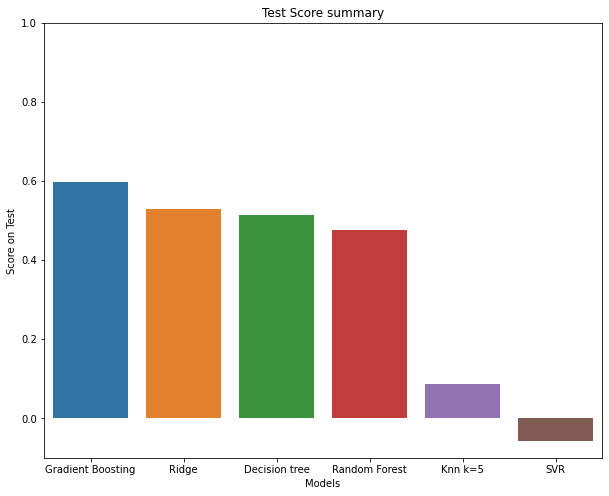

In [ ]:
models_np = np.array(models)
score_test_np = np.array(score_test)

summary_models_score_test={'Models':models_np,'Score on Test':score_test_np}
df_summary_models_score_test = pd.DataFrame(summary_models_score_test)
df_summary_models_score_test.sort_values(by=['Score on Test'],ascending=False,inplace=True)

#Define size of bar plot
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=df_summary_models_score_test['Models'], y=df_summary_models_score_test['Score on Test'])

# Add chart labels
plt.title('Test Score summary')
plt.ylim(-0.1, 1)


### Try log of target for best model : Gradient Boosting

Score with cross val :  [0.69169298 0.8062923  0.7715453  0.79064077 0.75305752]
Score on test with log(target) 0.7574297913695591


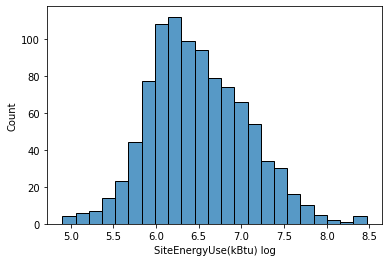

In [ ]:
# Get log of 'SiteEnergyUse(kBtu)'
df_cleaned['SiteEnergyUse(kBtu) log'] = np.log10(df_cleaned['SiteEnergyUse(kBtu)'])
df_cleaned.drop('SiteEnergyUse(kBtu)', inplace=True, axis=1)
sns.histplot(df_cleaned['SiteEnergyUse(kBtu) log'])

# Redefine target
y_log = df_cleaned.loc[:, ['SiteEnergyUse(kBtu) log']]

X_train, X_test, y_train, y_test = train_test_split(X, y_log, random_state=0, train_size = 0.75)

cv= KFold(n_splits=5, random_state=1, shuffle=True)

regression = GradientBoostingRegressor()
model_gb = make_pipeline(preprocessor, scaler, regression)

print('Score with cross val : ' , cross_val_score(model_gb, X_train, y_train.values.ravel(), cv=cv))

model_gb.fit(X_train, y_train.values.ravel())

print('Score on test with log(target)', model_gb.score(X_test,y_test))


## Step 3 : Model Optimization of hyperparameters with Gridsearch (with log(target))

In [ ]:
# Create three list that will gathers the test and train score associated to the model
models_list = []
train_score = []
test_score = []


### Gridsearch Ridge

In [ ]:
models_list.append('Ridge')
param_grid = {
    'ridge__alpha': [150,200,300,400]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_ridge, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())
print('Best param', grid_search.best_params_)

# Input the best parameters found
regression_ridge = Ridge(alpha=grid_search.best_params_['ridge__alpha'])
model_ridge_final = make_pipeline(preprocessor, scaler, regression_ridge)

model_ridge_final.fit(X_train, y_train.values.ravel())
print('Score on train', model_ridge_final.score(X_train,y_train))
print('Score on test', model_ridge_final.score(X_test,y_test))
train_score.append(model_ridge_final.score(X_train,y_train))
test_score.append(model_ridge_final.score(X_test,y_test))





Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best param {'ridge__alpha': 150}
Score on train 0.7119993294910416
Score on test 0.532470807376475


### Gridsearch Random forest

In [ ]:
models_list.append('Random forest')

param_grid = {
    'randomforestregressor__min_samples_leaf': [2,5,10],
    'randomforestregressor__n_estimators': [100, 200, 300, 400,500]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_randomforest, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())
print('Best param', grid_search.best_params_)





Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best param {'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__n_estimators': 400}


In [ ]:
# Input the best parameters found
regression = RandomForestRegressor(min_samples_leaf=grid_search.best_params_['randomforestregressor__min_samples_leaf'], n_estimators=grid_search.best_params_['randomforestregressor__n_estimators'])
model_randomforest_final = make_pipeline(preprocessor, scaler, regression)

model_randomforest_final.fit(X_train, y_train.values.ravel())

print('Score on train', model_randomforest_final.score(X_train,y_train))
print('Score on test', model_randomforest_final.score(X_test,y_test))
train_score.append(model_randomforest_final.score(X_train,y_train))
test_score.append(model_randomforest_final.score(X_test,y_test))



Score on train 0.937115101508467
Score on test 0.7365948916395542


### Gridsearch Decision tree

In [ ]:
models_list.append('Decision tree')
regression = DecisionTreeRegressor()
model_decisiontree = make_pipeline(preprocessor, scaler, regression)
model_decisiontree.fit(X_train, y_train.values.ravel())
print('Score on test', model_decisiontree.score(X_test,y_test.values.ravel()))

param_grid = {"decisiontreeregressor__splitter":["best","random"],
            "decisiontreeregressor__max_depth" : [1,5,10,50,100],
           "decisiontreeregressor__min_samples_leaf":[2,5,10,15],
           "decisiontreeregressor__max_features":["auto"],
           "decisiontreeregressor__max_leaf_nodes":[50,200,400,600]
}


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_decisiontree, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())
print('Best param', grid_search.best_params_)



Score on test 0.607799804773171
Fitting 4 folds for each of 160 candidates, totalling 640 fits
Best param {'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__max_leaf_nodes': 600, 'decisiontreeregressor__min_samples_leaf': 2, 'decisiontreeregressor__splitter': 'best'}


In [ ]:
# Input the best parameters found
regression_decisiontree = DecisionTreeRegressor(max_depth= grid_search.best_params_['decisiontreeregressor__max_depth'], max_leaf_nodes= grid_search.best_params_['decisiontreeregressor__max_leaf_nodes'], min_samples_leaf=grid_search.best_params_['decisiontreeregressor__min_samples_leaf'], splitter=grid_search.best_params_['decisiontreeregressor__splitter'])
model_decisiontree = make_pipeline(preprocessor, scaler, regression_decisiontree)

model_decisiontree.fit(X_train, y_train.values.ravel())
print('Score on train', model_decisiontree.score(X_train,y_train))
print('Score on test', model_decisiontree.score(X_test,y_test))
train_score.append(model_decisiontree.score(X_train,y_train))
test_score.append(model_decisiontree.score(X_test,y_test))


Score on train 0.789065412898293
Score on test 0.7011245852721708


###Gridsearch Gradientboosting

In [ ]:
models_list.append('Gradient Boosting')

regression = GradientBoostingRegressor()
model_gb = make_pipeline(preprocessor, scaler, regression)
model_gb.fit(X_train, y_train.values.ravel())
print('Score on test', model_gb.score(X_test,y_test.values.ravel()))

param_grid = {'gradientboostingregressor__learning_rate': [0.1,0.3,0.5],
                  'gradientboostingregressor__n_estimators' : [80,100],
                  'gradientboostingregressor__max_depth'    : [2,10,50]
                 }


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_gb, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())
print('Best param', grid_search.best_params_)

Score on test 0.7587317846905101
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best param {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 2, 'gradientboostingregressor__n_estimators': 100}


In [ ]:
regression_gb = GradientBoostingRegressor(learning_rate = grid_search.best_params_['gradientboostingregressor__learning_rate'], max_depth=grid_search.best_params_['gradientboostingregressor__max_depth'], n_estimators= grid_search.best_params_['gradientboostingregressor__n_estimators'])
model_gb = make_pipeline(preprocessor, scaler, regression_gb)

model_gb.fit(X_train, y_train.values.ravel())
print('Score on train', model_gb.score(X_train,y_train))
print('Score on test', model_gb.score(X_test,y_test))

train_score.append(model_gb.score(X_train,y_train))
test_score.append(model_gb.score(X_test,y_test))

Score on train 0.8355002879427785
Score on test 0.7591296947382751


### Summary plot gridsearch Score train/test

(0.0, 1.0)

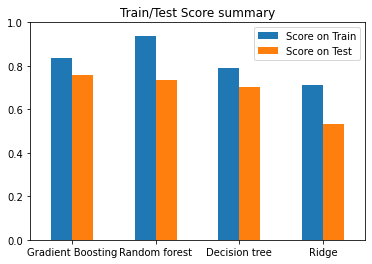

In [ ]:
models_np = np.array(models_list)
score_train_np = np.array(train_score)
score_test_np = np.array(test_score)

summary_models_score_test=({'Models':models_np,'Score on Train':score_train_np,'Score on Test':score_test_np})
df_summary_models_score_test = pd.DataFrame(summary_models_score_test,index=models_np)
df_summary_models_score_test.sort_values(by=['Score on Test'],ascending=False,inplace=True)


#Plot Searborn bar chart
ax = df_summary_models_score_test.plot.bar(rot=0)

# Add chart labels
plt.title('Train/Test Score summary')
plt.ylim(0, 1)

## Step 4 : Does adding energy Star Score improve the model ? 

In [ ]:
df = pd.read_csv('/content/df_cleaned.csv')
features_predict_energy = ['PrimaryPropertyType',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFABuilding(s)','PropertyGFAParking','ENERGYSTARScore']

df['SiteEnergyUse(kBtu) log'] = np.log10(df['SiteEnergyUse(kBtu)'])
df.drop('SiteEnergyUse(kBtu)', inplace=True, axis=1)

X = df.loc[:, features_predict_energy]
y_log = df.loc[:, ['SiteEnergyUse(kBtu) log']]


X_train, X_test, y_train, y_test = train_test_split(X, y_log, random_state=0, train_size = 0.75)

regression_gb = GradientBoostingRegressor(learning_rate = 0.1, max_depth=2, n_estimators= 100, subsample= 1)
model_gb = make_pipeline(preprocessor, scaler, regression_gb)

model_gb.fit(X_train, y_train.values.ravel())
print('Score on train', model_gb.score(X_train,y_train))
print('Score on test', model_gb.score(X_test,y_test))



Score on train 0.9094654766014292
Score on test 0.862867570824676


### Feature importance

                           feature_names  feature_importance
133               PropertyGFABuilding(s)            0.632164
135                      ENERGYSTARScore            0.105659
14                     cat__x0_Warehouse            0.079236
132                       NumberofFloors            0.053662
13   cat__x0_Supermarket / Grocery Store            0.048404
134                   PropertyGFAParking            0.028939
0            cat__x0_Distribution Center            0.017524
15              cat__x0_Worship Facility            0.006424
7                          cat__x0_Other            0.006099
1                       cat__x0_Hospital            0.004806


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


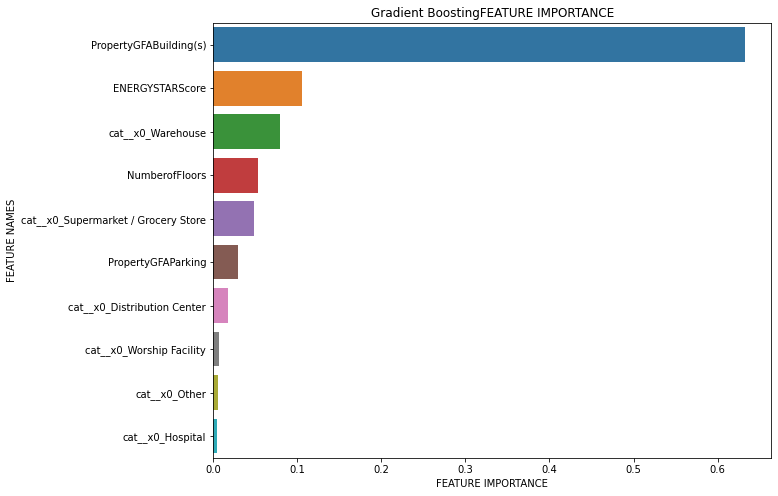

In [ ]:
feature_names = model_gb[0].get_feature_names()
feature_importance = model_gb[2].feature_importances_

def plot_feature_importance(importance,names,model_type):
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)
  
  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'],ascending=False,inplace=True)
  fi_df = fi_df.head(10)
  print(fi_df)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

plot_feature_importance(feature_importance,feature_names,'Gradient Boosting')

